# Cats vs Dogs recognition using Data Augmentation

## I. Chạy các thư viện 
### các thư viện như
* Tensorflow
* keras
* matplotlib
* ...

In [1]:
import numpy as np 

import random
import json
import csv

from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers

import os

In [2]:
np.random.seed(1337)

## II. Chạy các thư mục có chứa hình ảnh

In [4]:
TRAIN_DIR = 'input/train/'
TEST_DIR = 'input/test/'

ROWS = 150
COLS = 150
CHANNELS = 3

BATCH_SIZE=50

In [5]:
original_train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# slice datasets for memory efficiency on Kaggle Kernels, delete if using full datase
original_train_images = train_dogs[:5000] + train_cats[:5000]
random.shuffle(original_train_images)
# test_images =  test_images[:100]

# section = int(len(original_train_images) * 0.8)
train_images = original_train_images[:8000]
validation_images = original_train_images[8000:]

### 1. Ta có 8000 hình ảnh luyệt tập và 2000 hình ảnh kiểm thử

In [6]:
print(len(train_images))
print(len(validation_images))

8000
2000


### 2. Phân loại hình ảnh cho máy học, dog.jpg sẽ được mặc định là 1 cat.jpf là 0

In [7]:
def prep_data(images):
    count = len(images)
    X = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float32)
    y = np.zeros((count,), dtype=np.float32)
    
    for i, image_file in enumerate(images):
        img = image.load_img(image_file, target_size=(ROWS, COLS))
        X[i] = image.img_to_array(img)
        if 'dog' in image_file:
            y[i] = 1.
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return X, y

In [9]:
X_train, y_train = prep_data(train_images)

Processed 0 of 8000
Processed 1000 of 8000
Processed 2000 of 8000
Processed 3000 of 8000
Processed 4000 of 8000
Processed 5000 of 8000
Processed 6000 of 8000
Processed 7000 of 8000


In [16]:
print(X_train.shape)
print(y_train.shape)

(8000, 150, 150, 3)
(8000,)


In [10]:
X_validation, y_validation = prep_data(validation_images)

Processed 0 of 2000
Processed 1000 of 2000


In [67]:
print(X_validation.shape)
print(y_validation.shape)

In [ ]:
### lưu tất cả các X_train 

In [12]:
np.savez('NPZ/cats_v_dogs_train_data.npz',X_train)
np.savez('NPZ/cats_v_dogs_train_labels.npz',y_train)
np.savez('NPZ/cats_v_dogs_val_data.npz',X_validation)
np.savez('NPZ/cats_v_dogs_val_labels.npz',y_validation)

In [3]:
def load_data_training_and_test(dataset_name):
    npz_file = np.load(dataset_name+'_train_data.npz')
    train = npz_file['arr_0']

    npz_file = np.load(dataset_name+'_train_labels.npz')
    train_labels = npz_file['arr_0']

    npz_file = np.load(dataset_name+'_val_data.npz')
    val = npz_file['arr_0']

    npz_file = np.load(dataset_name+'_val_labels.npz')
    val_labels = npz_file['arr_0']
    return (train,train_labels),(val,val_labels)

(X_train,y_train),(X_validation,y_validation) = load_data_training_and_test('NPZ/cats_v_dogs')
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)

(8000, 150, 150, 3)
(8000,)
(2000, 150, 150, 3)
(2000,)


## III. Dùng phương pháp data augmentation
![title](img/picture.png)
### Thay đổi hình thái như
* rescale
* flip
* zoom
* shear

In [8]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = image.ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow(
    X_validation,
    y_validation,
    batch_size=BATCH_SIZE)

In [10]:
# Based model from https://www.kaggle.com/keogh24/dogs-v-cats-keras
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(ROWS, COLS, CHANNELS)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dense(1000, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [11]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0

In [128]:
import tensorflow as tf
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adamax(lr=0.001),
              metrics=['acc'])

In [129]:
train_steps = len(train_images)//BATCH_SIZE
validation_steps = len(validation_images)//BATCH_SIZE

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps =validation_steps
    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 160 steps, validate for 40 steps
Epoch 1/20
160/160 [==============================] - 151s 945ms/step - loss: 0.6704 - acc: 0.5798 - val_loss: 0.6652 - val_acc: 0.5920
Epoch 2/20
160/160 [==============================] - 141s 884ms/step - loss: 0.6152 - acc: 0.6515 - val_loss: 0.5698 - val_acc: 0.7020
Epoch 3/20
160/160 [==============================] - 141s 884ms/step - loss: 0.5778 - acc: 0.6919 - val_loss: 0.5762 - val_acc: 0.6970
Epoch 4/20
160/160 [==============================] - 141s 883ms/step - loss: 0.5658 - acc: 0.7046 - val_loss: 0.5542 - val_acc: 0.7255
Epoch 5/20
160/160 [==============================] - 142s 886ms/step - loss: 0.5472 - acc: 0.7191 - val_loss: 0.5232 - val_acc: 0.7450
Epoch 6/20
160/160 [==============================] - 141s 884ms/step - loss: 0.5397 - acc: 0.7211 - val_loss: 0.4919 - val_acc: 0.7655
Epoch 7/20
160/160 [==============================] - 141s 883ms/step - loss: 0.5225 - acc:

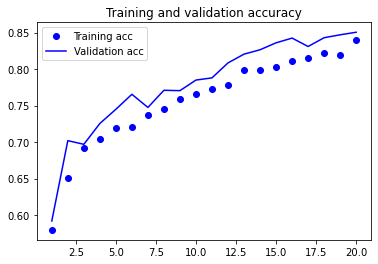

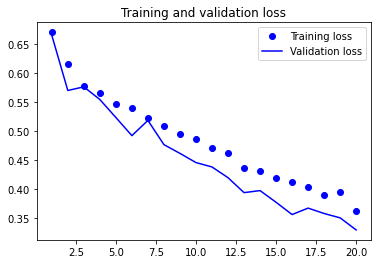

In [130]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [131]:
model.save('dogs-v-cat-data-augmentation-V2.h5')

## Test độ chính xác

In [33]:
evaluation_images = train_dogs[5000:6000] + train_cats[5000:6000]
random.shuffle(evaluation_images)

X_evaluation, y_evaluation = prep_data(evaluation_images)
X_evaluation /= 255

Processed 0 of 2000
Processed 1000 of 2000


In [30]:
np.savez('NPZ/X_evalute.npz',X_evaluation)
np.savez('NPZ/y_evalute.npz',y_evaluation)

* Lưu các giá trị vào npz

In [13]:
npz_file = np.load('NPZ/X_evalute.npz')
X_evaluation = npz_file['arr_0']

npz_file = np.load('NPZ/y_evalute.npz')
y_evaluation = npz_file['arr_0']

In [15]:
from tensorflow.keras.models import load_model
model = load_model('dogs-v-cat-data-augmentation-V2.h5')
# model = load_model('dogs-v-cat-data-augmentation-V3.h5')

In [16]:
evaluation = model.evaluate(X_evaluation, y_evaluation)

2000/2000 [==============================] - 16s 8ms/sample - loss: 0.3472 - acc: 0.8470


In [17]:
print(f"Val_Loss:     {round(evaluation[0]*100,2)}%")
print(f"Val_Accuracy: {round(evaluation[1]*100,2)}%")

Val_Loss:     34.72%
Val_Accuracy: 84.7%


In [46]:
print(evaluation)

[0.34721719813346863, 0.847]


Text(0, 0.5, 'Marks')

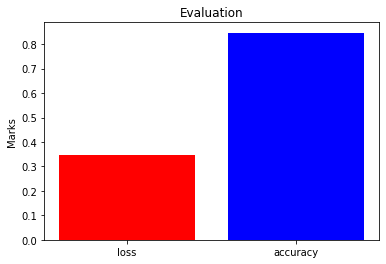

In [18]:
label = ['loss', 'accuracy']
color = ['r','b']
plt.bar(label,evaluation,color = color)
plt.title("Evaluation")
plt.ylabel("Marks")


In [10]:
X_test, _ = prep_data(test_images)
X_test /= 255.

Processed 0 of 12500
Processed 1000 of 12500
Processed 2000 of 12500
Processed 3000 of 12500
Processed 4000 of 12500
Processed 5000 of 12500
Processed 6000 of 12500
Processed 7000 of 12500
Processed 8000 of 12500
Processed 9000 of 12500
Processed 10000 of 12500
Processed 11000 of 12500
Processed 12000 of 12500


In [11]:
np.savez('NPZ/X_test.npz',X_test)

In [3]:
npz_file = np.load('NPZ/X_test.npz')
X_test = npz_file['arr_0']

In [5]:
predictions = model.predict(X_test)

I am 99.94% sure this is a Dog


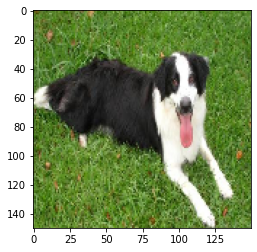

I am 98.93% sure this is a Dog


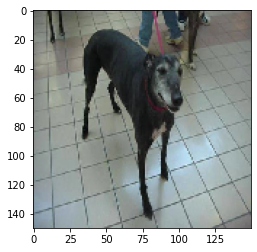

I am 68.04% sure this is a Dog


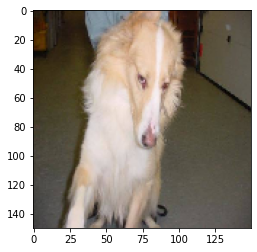

I am 99.65% sure this is a Dog


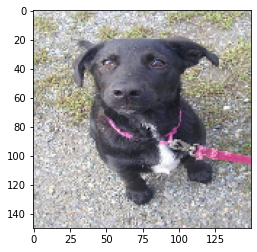

I am 83.45% sure this is a Dog


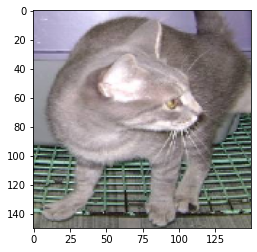

I am 51.48% sure this is a Cat


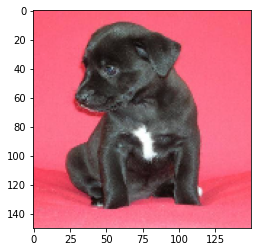

I am 73.29% sure this is a Cat


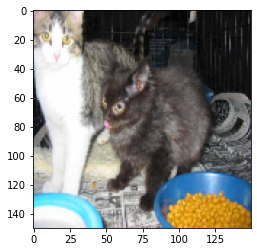

I am 68.45% sure this is a Cat


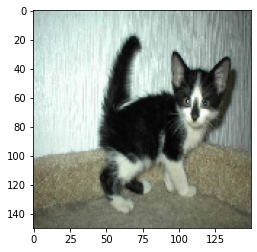

I am 92.74% sure this is a Cat


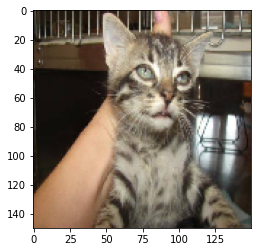

I am 98.36% sure this is a Cat


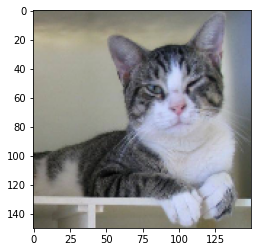

In [8]:
for i in range(0,10):
    rand  = np.random.randint(0,len(X_test))
    if predictions[rand, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[rand][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[rand][0]))

    plt.imshow(image.array_to_img(X_test[rand]))
    plt.show()

## Dùng hình ảnh khác để test

In [19]:
TEST_USER = 'test_from_user/'
test_images_user =  [TEST_USER+i for i in os.listdir(TEST_USER)]

In [20]:
X_test_user, _ = prep_data(test_images_user)
X_test_user /= 255.

Processed 0 of 7


In [21]:
predictions_user = model.predict(X_test_user)

I am 57.01% sure this is a Cat


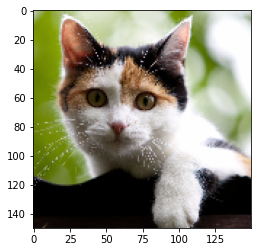

I am 51.41% sure this is a Cat


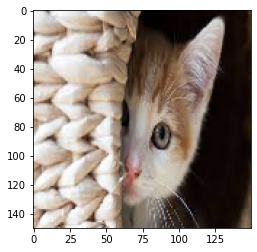

I am 96.69% sure this is a Dog


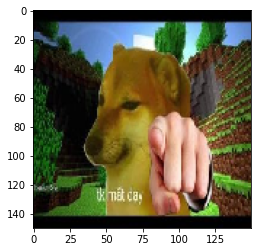

I am 82.08% sure this is a Dog


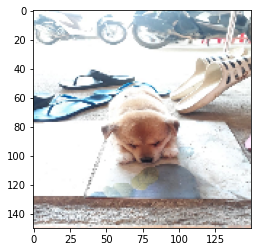

I am 56.19% sure this is a Cat


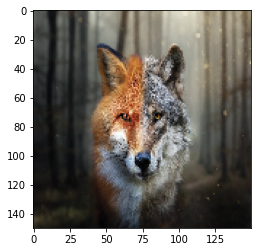

I am 57.21% sure this is a Cat


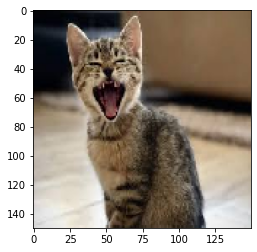

I am 98.07% sure this is a Cat


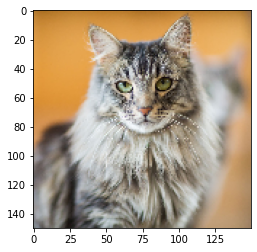

In [22]:
for i in range(0,len(X_test_user)):
    if predictions_user[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions_user[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions_user[i][0]))

    plt.imshow(image.array_to_img(X_test_user[i]))
    plt.show()

## Phần test cài môi trường

In [28]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.3
Scikit-Learn 0.24.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
